# Libraries

In [1]:
import torch
from torch import nn
import torch.onnx
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import numpy as np
import pandas as pd
import json
import glob
import ast
import gzip
import os
import yaml
from tqdm import tqdm
import re
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import copy

from IPython.display import display, clear_output
from tqdm.notebook import tqdm

# Functions

## Two Path

In [ ]:
class TwoPathNN(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dims1, hidden_dims2, combined_hidden_dims, output_dim=1):
        """
        Initialize the neural network.

        Parameters:
        - input_dim1: Dimension of the first set of features.
        - input_dim2: Dimension of the second set of features.
        - hidden_dims1: List of hidden layer dimensions for the first network.
        - hidden_dims2: List of hidden layer dimensions for the second network.
        - combined_hidden_dims: List of hidden layer dimensions for the combined network after merging the two paths.
        - output_dim: Dimension of the output. Defaults to 1 for a single scalar output.
        """
        super(TwoPathNN, self).__init__()
        
        # Define the first path
        self.path1 = self._make_layers(input_dim1, hidden_dims1)
        
        # Define the second path
        self.path2 = self._make_layers(input_dim2, hidden_dims2)
        
        # Define the combined network
        combined_input_dim = hidden_dims1[-1] + hidden_dims2[-1]  # Last layer sizes of both paths
        self.combined = self._make_layers(combined_input_dim, combined_hidden_dims, output_dim)

    def _make_layers(self, input_dim, hidden_dims, output_dim=None):
        """
        Helper function to create a sequence of layers.
        """
        layers = []
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim  # Update input_dim for the next layer
        if output_dim:
            layers.append(nn.Linear(hidden_dims[-1], output_dim))
        return nn.Sequential(*layers)

    def forward(self, x1, x2):
        """
        Forward pass through the network.

        Parameters:
        - x1: Input for the first path.
        - x2: Input for the second path.
        """
        out1 = self.path1(x1)
        out2 = self.path2(x2)
        
        # Concatenate the outputs from both paths
        combined_out = torch.cat((out1, out2), dim=1)
        
        # Pass through the combined network
        out = self.combined(combined_out)
        #return nn.ReLU(out,dim=1)
        #return torch.sigmoid(out)
        #return nn.functional.softmax(out, dim=1)
        return out
#############################################################################################################
def export_model_to_onnx(model, x1, x2, onnx_file_name):
    """
    Export a PyTorch model to ONNX format.

    Parameters:
    - model: The PyTorch model to export.
    - x1: The first input tensor to the model.
    - x2: The second input tensor to the model.
    - onnx_file_name: The filename for the exported ONNX model.
    """
    model.eval()  # Set the model to evaluation mode
    
    # Combine x1 and x2 into a tuple, as expected by torch.onnx.export
    model_input = (x1, x2)
    
    # Export the model to an ONNX file
    torch.onnx.export(model,               
                      model_input,         
                      onnx_file_name,      
                      export_params=True,  # store the trained parameter weights inside the model file
                      opset_version=11,    
                      do_constant_folding=True,  # whether to execute constant folding for optimization
                      input_names=['players', 'monsters'],  # the model's input names
                      output_names=['HP-ratio'],  # the model's output names
                      dynamic_axes={'players': {0: 'batch_size'},  # variable-length axes
                                    'monsters': {0: 'batch_size'},
                                    'HP-ratio': {0: 'batch_size'}})
    
#############################################################################################################
def train_one_epoch(model, train_loader, criterion, optimizer,device):
    """
    Train the model for one epoch.
    """
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs1, inputs2, labels in train_loader:
        inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs1, inputs2)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        running_loss += loss.item()
    return running_loss / len(train_loader)

def plot_losses(fig,ax,losses, update_every_n_epochs, epoch):
    """
    Update the training loss plot.
    """
    if (epoch + 1) % update_every_n_epochs == 0:
        ax.clear()
        ax.plot(losses, label='Training Loss')
        ax.set_yscale('log')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.set_title('Training Loss Over Epochs')
        ax.legend()
        display(fig)
        clear_output(wait=True)

    return (fig,ax)

def check_early_stopping(epoch_loss, best_loss, min_loss_change, wait, patience):
    """
    Check for early stopping.
    """
    if epoch_loss < best_loss - min_loss_change:
        best_loss = epoch_loss
        wait = 0
    else:
        wait += 1
    if wait >= patience:
        print("\nEarly stopping triggered.")
        return True, best_loss, wait
    return False, best_loss, wait

# Training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=2000, update_every_n_epochs=5, min_loss_change=1e-6, patience=20):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    losses = []
    wait = 0
    best_loss = np.inf

    # Initialize plotting
    fig, ax = plt.subplots(figsize=(10, 5))

    for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
        epoch_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        losses.append(epoch_loss)
        
        # Update plot
        fig,ax = plot_losses(fig, ax, losses, update_every_n_epochs, epoch)
        
        # Check for early stopping
        early_stop, best_loss, wait = check_early_stopping(epoch_loss, best_loss, min_loss_change, wait, patience)
        if early_stop:
            break
        
    fig, ax = plot_losses(fig, ax, losses, 1, epoch)
    print('Finished Training')
    return losses

############################################################

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []
    with torch.no_grad():  # Disables gradient computation
        for inputs1, inputs2, labels in data_loader:
            outputs = model(inputs1, inputs2)
            predicted = outputs.data.cpu().numpy()  # Ensure outputs are moved to CPU before converting to numpy
            actual = labels.data.cpu().numpy()
            predictions.extend(predicted)
            actuals.extend(actual)
    return np.array(predictions), np.array(actuals)

def validate_model(model, data_loader):
    """
    Compute the Mean Squared Error (MSE) for the model on a validation set.

    Parameters:
    - model: The PyTorch model to evaluate.
    - data_loader: DataLoader for the validation dataset.
    
    Returns:
    - mse: The Mean Squared Error of the model predictions against actual targets.
    """
    predictions, actuals = evaluate_model(model, data_loader)
    mse = mean_squared_error(actuals, predictions)
    print(f"Mean Squared Error: {mse}")
    return mse

def plot_predictions_vs_actuals(actuals, predictions,mse=None,title=None):
    plt.figure(figsize=(8, 8))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    if title:
        plt.title(title)
    else:
        plt.title('Predictions vs. Actuals')
    plt.plot(np.linspace(min(actuals), max(actuals), 100), 
             np.linspace(min(actuals), max(actuals), 100), 
             color='black', linestyle='--')  # Reference line
    if mse:
        plt.text(x=0.01,y=0.9,s="MSE=%0.2f"%mse)
    plt.grid(True)
    plt.show()

############################################################
def scale_tensors(train_tensor, val_tensor):
    """Scale tensors for training and validation."""
    mean = torch.mean(train_tensor, dim=0)
    std = torch.std(train_tensor, dim=0)
    train_scaled = (train_tensor - mean) / std
    val_scaled = (val_tensor - mean) / std
    return train_scaled, val_scaled

def cross_validate_model(x1_df, x2_df, Y_df, num_epochs=2000, k_folds=5, batch_size=32):
    """
    Performs cross-validation with scaling.

    Args:
    - x1_df: The x1 input features as a Pandas DataFrame.
    - x2_df: The x2 input features as a Pandas DataFrame.
    - Y_df: The labels as a Pandas DataFrame or Series.
    - num_epochs: The number of epochs for training.
    - k_folds: The number of folds for cross-validation.
    - batch_size: The batch size for training.

    Returns:
    - fold_losses: A list of loss values for each fold.
    """
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=0)
    fold_losses = []
    
    # Convert DataFrame to numpy arrays for KFold compatibility
    X1 = x1_df.values
    X2 = x2_df.values
    Y = Y_df.values if isinstance(Y_df, pd.DataFrame) else Y_df.to_numpy()
    
    # Hardcoded model architecture parameters
    input_dim1 = len(x1_df.columns)
    input_dim2 = len(x2_df.columns)
    hidden_dims1 = [40, 80, 80, 40]
    hidden_dims2 = [40, 80, 80, 40]
    combined_hidden_dims = [80, 40, 20]
    
    for fold, (train_ids, test_ids) in enumerate(kfold.split(Y)):
        print(f'FOLD {fold}')
        print('--------------------------------')
        
        # Split data for x1, x2, and Y
        x1_train, x1_val = X1[train_ids], X1[test_ids]
        x2_train, x2_val = X2[train_ids], X2[test_ids]
        y_train, y_val = Y[train_ids], Y[test_ids]

        # Scaling
        x1_train, x1_val = scale_tensors(torch.tensor(x1_train, dtype=torch.float), torch.tensor(x1_val, dtype=torch.float))
        x2_train, x2_val = scale_tensors(torch.tensor(x2_train, dtype=torch.float), torch.tensor(x2_val, dtype=torch.float))
        y_train, y_val = torch.tensor(y_train, dtype=torch.float), torch.tensor(y_val, dtype=torch.float)

        # DataLoader for the training and validation data
        train_loader = DataLoader(TensorDataset(x1_train, x2_train, y_train), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(x1_val, x2_val, y_val), batch_size=batch_size)

        # Initialize model, criterion, and optimizer for the current fold
        model = TwoPathNN(input_dim1, input_dim2, hidden_dims1, hidden_dims2, combined_hidden_dims)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.AdamW(model.parameters())
        
        # Train the model
        losses = train_model(model, train_loader, criterion, optimizer, num_epochs)

        # Validate the model
        val_loss = validate_model(model, val_loader)
        fold_losses.append(val_loss)
        print(f'Fold {fold} | Validation Loss: {val_loss}')
        ############################################################################
        predictions, actuals = evaluate_model(model, train_loader)
        mse = mean_squared_error(actuals, predictions)
        print(f"Mean Squared Error: {mse}")
        plot_predictions_vs_actuals(actuals, predictions,mse=mse,title="Training")
        ############################################################################
        predictions, actuals = evaluate_model(model, val_loader)
        mse = mean_squared_error(actuals, predictions)
        print(f"Mean Squared Error: {mse}")
        plot_predictions_vs_actuals(actuals, predictions,mse=mse,title="Validation")
    
    return fold_losses

## One Path

In [ ]:
class OnePathNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim=1):
        """
        Initialize the neural network.

        Parameters:
        - input_dim: Dimension of the features.
        - hidden_dims: List of hidden layer dimensions.
        - output_dim: Dimension of the output. Defaults to 1 for a single scalar output.
        """
        super(OnePathNN, self).__init__()
        
        # Define the first path
        self.path = self._make_layers(input_dim, hidden_dims, output_dim)

    def _make_layers(self, input_dim, hidden_dims, output_dim=None):
        """
        Helper function to create a sequence of layers.
        """
        layers = []
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim  # Update input_dim for the next layer
        if output_dim:
            layers.append(nn.Linear(hidden_dims[-1], output_dim))
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass through the network.

        Parameters:
        - x: Input.
        """
        # Pass through the combined network
        out = self.path(x)
        #return nn.ReLU(out,dim=1)
        #return torch.sigmoid(out)
        #return nn.functional.softmax(out, dim=1)
        return out
    
def export_model_to_onnx(model, x, onnx_file_name):
    """
    Export a PyTorch model to ONNX format.

    Parameters:
    - model: The PyTorch model to export.
    - x: The input tensor to the model.
    - onnx_file_name: The filename for the exported ONNX model.
    """
    model.eval()  # Set the model to evaluation mode
    
    # Combine x into a tuple, as expected by torch.onnx.export
    model_input = (x)
    
    # Export the model to an ONNX file
    torch.onnx.export(model,               
                      model_input,         
                      onnx_file_name,      
                      export_params=True,  # store the trained parameter weights inside the model file
                      opset_version=11,    
                      do_constant_folding=True,  # whether to execute constant folding for optimization
                      input_names=['players-monsters'],  # the model's input names
                      output_names=['HP-ratio'],  # the model's output names
                      dynamic_axes={'players-monsters': {0: 'batch_size'},  # variable-length axes
                                    'HP-ratio': {0: 'batch_size'}})
    

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    return running_loss / len(train_loader)

def plot_losses(fig,ax,losses, update_every_n_epochs, epoch):
    """
    Update the training loss plot.
    """
    if (epoch + 1) % update_every_n_epochs == 0:
        ax.clear()
        ax.plot(losses, label='Training Loss')
        ax.set_yscale('log')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Training Loss Over Epochs')
        ax.legend()
        display(fig)
        clear_output(wait=True)

    return (fig,ax)

def check_early_stopping(epoch_loss, best_loss, min_loss_change, wait, patience):
    """
    Check for early stopping.
    """
    if epoch_loss < best_loss - min_loss_change:
        best_loss = epoch_loss
        wait = 0
    else:
        wait += 1
    if wait >= patience:
        print("\nEarly stopping triggered.")
        return True, best_loss, wait
    return False, best_loss, wait

# Training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=2000, update_every_n_epochs=5, min_loss_change=1e-6, patience=20):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    losses = []
    wait = 0
    best_loss = np.inf

    # Initialize plotting
    fig, ax = plt.subplots(figsize=(10, 5))

    for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
        epoch_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        losses.append(epoch_loss)
        
        # Update plot
        fig,ax = plot_losses(fig, ax, losses, update_every_n_epochs, epoch)
        
        # Check for early stopping
        early_stop, best_loss, wait = check_early_stopping(epoch_loss, best_loss, min_loss_change, wait, patience)
        if early_stop:
            break
        
    fig, ax = plot_losses(fig, ax, losses, 1, epoch)
    print('Finished Training')
    return losses


def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs
            outputs = model(inputs)
            predicted = outputs.data.cpu().numpy()
            actual = labels.data.cpu().numpy()
            predictions.extend(predicted)
            actuals.extend(actual)
    return np.array(predictions), np.array(actuals)

def validate_model(model, data_loader):
    """
    Compute the Mean Squared Error (MSE) for the model on a validation set.

    Parameters:
    - model: The PyTorch model to evaluate.
    - data_loader: DataLoader for the validation dataset.
    
    Returns:
    - mse: The Mean Squared Error of the model predictions against actual targets.
    """
    predictions, actuals = evaluate_model(model, data_loader)
    mse = mean_squared_error(actuals, predictions)
    print(f"Mean Squared Error: {mse}")
    return mse

def plot_predictions_vs_actuals(actuals, predictions,mse=None,title=None):
    plt.figure(figsize=(8, 8))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    if title:
        plt.title(title)
    else:
        plt.title('Predictions vs. Actuals')
    plt.plot(np.linspace(min(actuals), max(actuals), 100), 
             np.linspace(min(actuals), max(actuals), 100), 
             color='black', linestyle='--')  # Reference line
    if mse:
        plt.text(x=0.01,y=0.9,s="MSE=%0.2f"%mse)
    plt.grid(True)
    plt.show()

############################################################
def scale_tensors(train_tensor, val_tensor):
    """Scale tensors for training and validation."""
    mean = torch.mean(train_tensor, dim=0)
    std = torch.std(train_tensor, dim=0)
    train_scaled = (train_tensor - mean) / std
    val_scaled = (val_tensor - mean) / std
    return train_scaled, val_scaled


def cross_validate_model(x_df, Y_df, num_epochs=2000, k_folds=5, batch_size=32):
    """
    Performs cross-validation with scaling.

    Args:
    - x_df: The input features as a Pandas DataFrame.
    - Y_df: The labels as a Pandas DataFrame or Series.
    - num_epochs: The number of epochs for training.
    - k_folds: The number of folds for cross-validation.
    - batch_size: The batch size for training.

    Returns:
    - fold_losses: A list of loss values for each fold.
    """
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=0)
    fold_losses = []
    
    # Convert DataFrame to numpy arrays for KFold compatibility
    X = x_df.values
    Y = Y_df.values if isinstance(Y_df, pd.DataFrame) else Y_df.to_numpy()
    
    # Hardcoded model architecture parameters
    input_dim = len(x_df.columns)
    hidden_dims = [20, 40, 80, 80, 40,20]
    
    for fold, (train_ids, test_ids) in enumerate(kfold.split(Y)):
        print(f'FOLD {fold}')
        print('--------------------------------')
        
        # Split data for x, and Y
        x_train, x_val = X[train_ids], X[test_ids]
        y_train, y_val = Y[train_ids], Y[test_ids]

        # Scaling
        x_train, x_val = scale_tensors(torch.tensor(x_train, dtype=torch.float), torch.tensor(x_val, dtype=torch.float))
        y_train, y_val = torch.tensor(y_train, dtype=torch.float), torch.tensor(y_val, dtype=torch.float)

        # DataLoader for the training and validation data
        train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=batch_size)

        # Initialize model, criterion, and optimizer for the current fold
        model = OnePathNN(input_dim, hidden_dims)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.AdamW(model.parameters())
        
        # Train the model
        losses = train_model(model, train_loader, criterion, optimizer, num_epochs)

        # Validate the model
        val_loss = validate_model(model, val_loader)
        fold_losses.append(val_loss)
        print(f'Fold {fold} | Validation Loss: {val_loss}')
        ############################################################################
        predictions, actuals = evaluate_model(model, train_loader)
        mse = mean_squared_error(actuals, predictions)
        print(f"Mean Squared Error: {mse}")
        plot_predictions_vs_actuals(actuals, predictions,mse=mse,title="Training")
        ############################################################################
        predictions, actuals = evaluate_model(model, val_loader)
        mse = mean_squared_error(actuals, predictions)
        print(f"Mean Squared Error: {mse}")
        plot_predictions_vs_actuals(actuals, predictions,mse=mse,title="Validation")
    
    return fold_losses

## Common Functions

In [2]:
class OnePathNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim=1, dropout_rate=0.0):
        """
        Initialize the neural network.

        Parameters:
        - input_dim: Dimension of the features.
        - hidden_dims: List of hidden layer dimensions.
        - output_dim: Dimension of the output. Defaults to 1 for a single scalar output.
        """
        super(OnePathNN, self).__init__()
        
        # Define the first path
        self.path = self._make_layers(input_dim, hidden_dims, output_dim, dropout_rate)

    def _make_layers(self, input_dim, hidden_dims, output_dim=None, dropout_rate=0.1):
        """
        Helper function to create a sequence of layers.
        """
        layers = []
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = hidden_dim  # Update input_dim for the next layer
        if output_dim:
            layers.append(nn.Linear(hidden_dims[-1], output_dim))
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass through the network.

        Parameters:
        - x: Input.
        """
        # Pass through the combined network
        out = self.path(x)
        #return nn.ReLU(out,dim=1)
        #return torch.sigmoid(out)
        #return nn.functional.softmax(out, dim=1)
        return out

class TwoPathNN(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dims1, hidden_dims2, combined_hidden_dims, output_dim=1, dropout_rate=0.0):
        """
        Initialize the neural network.

        Parameters:
        - input_dim1: Dimension of the first set of features.
        - input_dim2: Dimension of the second set of features.
        - hidden_dims1: List of hidden layer dimensions for the first network.
        - hidden_dims2: List of hidden layer dimensions for the second network.
        - combined_hidden_dims: List of hidden layer dimensions for the combined network after merging the two paths.
        - output_dim: Dimension of the output. Defaults to 1 for a single scalar output.
        """
        super(TwoPathNN, self).__init__()
        
        # Define the first path
        self.path1 = self._make_layers(input_dim1, hidden_dims1)
        
        # Define the second path
        self.path2 = self._make_layers(input_dim2, hidden_dims2)
        
        # Define the combined network
        combined_input_dim = hidden_dims1[-1] + hidden_dims2[-1]  # Last layer sizes of both paths
        self.combined = self._make_layers(combined_input_dim, combined_hidden_dims, output_dim, dropout_rate)

    def _make_layers(self, input_dim, hidden_dims, output_dim=None, dropout_rate=0.1):
        """
        Helper function to create a sequence of layers.
        """
        layers = []
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = hidden_dim  # Update input_dim for the next layer
        if output_dim:
            layers.append(nn.Linear(hidden_dims[-1], output_dim))
        return nn.Sequential(*layers)

    def forward(self, x1, x2):
        """
        Forward pass through the network.

        Parameters:
        - x1: Input for the first path.
        - x2: Input for the second path.
        """
        out1 = self.path1(x1)
        out2 = self.path2(x2)
        
        # Concatenate the outputs from both paths
        combined_out = torch.cat((out1, out2), dim=1)
        
        # Pass through the combined network
        out = self.combined(combined_out)
        #return nn.ReLU(out,dim=1)
        #return torch.sigmoid(out)
        #return nn.functional.softmax(out, dim=1)
        return out
    
    def predict(self, inputs):
        self.eval()
        with torch.no_grad():
            x1, x2 = inputs[:, :input_dim1], inputs[:, input_dim1:]
            x1 = torch.tensor(x1, dtype=torch.float32)
            x2 = torch.tensor(x2, dtype=torch.float32)
            output = self.forward(x1, x2)
            #for classification, apply softmax/sigmoid
            return output.numpy()

def plot_losses(fig,ax,losses, update_every_n_epochs, epoch):
    """
    Update the training loss plot.
    """
    if (epoch + 1) % update_every_n_epochs == 0:
        ax.clear()
        ax.plot(losses, label='Training Loss')
        ax.set_yscale('log')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Training Loss Over Epochs')
        ax.legend()
        display(fig)
        clear_output(wait=True)

    return (fig,ax)

def check_early_stopping(epoch_loss, best_loss, min_loss_change, wait, patience):
    """
    Check for early stopping.
    """
    if epoch_loss < best_loss - min_loss_change:
        best_loss = epoch_loss
        wait = 0
    else:
        wait += 1
    if wait >= patience:
        print("\nEarly stopping triggered.")
        return True, best_loss, wait
    return False, best_loss, wait

def plot_predictions_vs_actuals(actuals, predictions,mse=None,title=None,filename=None):
    plt.figure(figsize=(8, 8))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.xlabel('Actual Values',size='xx-large')
    plt.ylabel('Predicted Values',size='xx-large')
    plt.xticks(size='xx-large')
    plt.yticks(size='xx-large')
    if title:
        plt.title(title,size='xx-large')
    else:
        plt.title('Predictions vs. Actuals',size='xx-large')
    plt.plot(np.linspace(min(actuals), max(actuals), 100), 
             np.linspace(min(actuals), max(actuals), 100), 
             color='black', linestyle='--')  # Reference line
    if mse:
        plt.text(x=0.01,y=0.9,s="MSE=%0.2f"%mse,size='xx-large')
    plt.grid(True)
    if filename:
        plt.savefig(filename,dpi=600,transparent=True)
    plt.show()

def scale_tensors(train_tensor, val_tensor):
    """Scale tensors for training and validation."""
    mean = torch.mean(train_tensor, dim=0)
    std = torch.std(train_tensor, dim=0)
    train_scaled = (train_tensor - mean) / std
    val_scaled = (val_tensor - mean) / std
    return train_scaled, val_scaled

def evaluate_model(model, data_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for batch in data_loader:
            if isinstance(model, OnePathNN):
                inputs, labels = batch
            else:  # Assuming TwoPathNN
                inputs1, inputs2, labels = batch[0], batch[1], batch[2]
                inputs = (inputs1, inputs2)
            
            if isinstance(inputs, tuple):  # For TwoPathNN
                outputs = model(*inputs)
            else:  # For OnePathNN
                outputs = model(inputs)
            
            predictions.extend(outputs.data.cpu().numpy())
            actuals.extend(labels.data.cpu().numpy())
    
    return np.array(predictions), np.array(actuals)

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        
        if isinstance(model, OnePathNN):
            inputs, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(inputs)
        else:  # Assuming TwoPathNN
            inputs1, inputs2, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)
            outputs = model(inputs1, inputs2)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    return running_loss / len(train_loader)

def export_model_to_onnx(model, inputs, onnx_file_name):
    model.eval()
    
    # Adjust input and output names based on the model type
    input_names = ['players', 'monsters'] if len(inputs) == 2 else ['players-monsters']
    output_names = ['HP-ratio']

    # Ensure inputs is a tuple for both model types
    inputs = (inputs,) if not isinstance(inputs, tuple) else inputs
    model_input = inputs

    # Define dynamic axes for variable batch sizes
    dynamic_axes = {name: {0: 'batch_size'} for name in input_names}
    dynamic_axes.update({output_names[0]: {0: 'batch_size'}})
    
    torch.onnx.export(model, model_input, onnx_file_name, export_params=True,
                      opset_version=11, do_constant_folding=True,
                      input_names=input_names, output_names=output_names,
                      dynamic_axes=dynamic_axes)

def validate_model(model, data_loader):
    """
    Compute the Mean Squared Error (MSE) for the model on a validation set.

    Parameters:
    - model: The PyTorch model to evaluate.
    - data_loader: DataLoader for the validation dataset.
    
    Returns:
    - mse: The Mean Squared Error of the model predictions against actual targets.
    """
    predictions, actuals = evaluate_model(model, data_loader)
    mse = mean_squared_error(actuals, predictions)
    #print(f"Mean Squared Error: {mse}")
    return mse

def train_model(model, train_loader, criterion, optimizer, num_epochs=2000, update_every_n_epochs=5, min_loss_change=1e-6, patience=20):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    losses = []
    wait = 0
    best_loss = np.inf

    # Initialize plotting
    fig, ax = plt.subplots(figsize=(10, 5))

    for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
        epoch_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        losses.append(epoch_loss)
        
        # Update plot
        fig,ax = plot_losses(fig, ax, losses, update_every_n_epochs, epoch)
        
        # Check for early stopping
        early_stop, best_loss, wait = check_early_stopping(epoch_loss, best_loss, min_loss_change, wait, patience)
        if early_stop:
            break
        
    fig, ax = plot_losses(fig, ax, losses, 1, epoch)
    print('Finished Training')
    return losses

def cross_validate_model(model_constructor, model_params, x_df, Y_df, x2_df=None, num_epochs=2000, k_folds=5, batch_size=32):
    """
    Performs cross-validation with scaling, compatible with both OnePathNN and TwoPathNN.

    Args:
    - model_constructor: The model class (OnePathNN or TwoPathNN).
    - model_params: Parameters to be passed to the model constructor.
    - x_df: The input features as a Pandas DataFrame for OnePathNN or x1 for TwoPathNN.
    - Y_df: The labels as a Pandas DataFrame or Series.
    - x2_df: The second set of input features as a Pandas DataFrame for TwoPathNN. Default is None.
    - num_epochs, k_folds, batch_size: Training and cross-validation parameters.

    Returns:
    - fold_losses: A list of validation loss values for each fold.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=0)
    fold_losses = []

    X1 = x_df.values
    Y = Y_df.values if isinstance(Y_df, pd.DataFrame) else Y_df.to_numpy()

    if x2_df is not None:
        X2 = x2_df.values

    for fold, (train_ids, test_ids) in enumerate(kfold.split(Y)):
        print(f'FOLD {fold}')
        print('--------------------------------')

        # Split data for x and Y. If x2_df is provided, also split x2.
        x1_train, x1_val = X1[train_ids], X1[test_ids]
        y_train, y_val = Y[train_ids], Y[test_ids]

        train_tensors = [torch.tensor(x1_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.float)]
        val_tensors = [torch.tensor(x1_val, dtype=torch.float), torch.tensor(y_val, dtype=torch.float)]

        if x2_df is not None:
            x2_train, x2_val = X2[train_ids], X2[test_ids]
            train_tensors.insert(1, torch.tensor(x2_train, dtype=torch.float))
            val_tensors.insert(1, torch.tensor(x2_val, dtype=torch.float))

        # Scaling
        for i in range(len(train_tensors) - 1): # Exclude Y tensor
            train_tensors[i], val_tensors[i] = scale_tensors(train_tensors[i], val_tensors[i])

        # DataLoader for the training and validation data
        train_loader = DataLoader(TensorDataset(*train_tensors), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(*val_tensors), batch_size=batch_size)

        # Initialize model, criterion, and optimizer for the current fold
        model = model_constructor(**model_params).to(device)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
        
        # Train the model
        losses = train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)
        
        # Validate the model
        val_loss = validate_model(model, val_loader)
        fold_losses.append(val_loss)
        print(f'Fold {fold} | Validation Loss: {val_loss}')

    average_loss = np.mean(fold_losses)
    print(f'Average Validation Loss across folds: {average_loss}')
    return fold_losses


In [3]:
def plot_losses(fig, ax, train_losses, val_losses, update_every_n_epochs, epoch, filename=None):
    """
    Update the training and validation loss plots.
    """
    if (epoch + 1) % update_every_n_epochs == 0:
        ax.clear()
        ax.plot(train_losses, label='Training Loss', color='blue')
        ax.plot(val_losses, label='Validation Loss', color='red')
        ax.set_yscale('log')
        ax.set_xlabel('Epochs',size='xx-large')
        ax.set_ylabel('Loss',size='xx-large')
        ax.tick_params(axis='x', labelsize='xx-large')
        ax.tick_params(axis='y', labelsize='xx-large')
        ax.tick_params(axis='y', which='minor', labelsize=0)
        ax.set_title('Loss Over Epochs',size='xx-large')
        ax.legend()
        if filename:
            plt.savefig(filename,dpi=600,transparent=True)
        display(fig)
        clear_output(wait=True)

    return (fig, ax)

def train_model(model, train_loader, criterion, optimizer, num_epochs=2000, update_every_n_epochs=5, min_loss_change=1e-6, patience=20, val_split=0.2, batch_size=32,filename=None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Extract dataset from the passed DataLoader
    dataset = train_loader.dataset
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size
    
    # Split the dataset into new training and validation sets
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create new DataLoaders for training and validation
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    wait = 0
    best_loss = np.inf

    # Initialize plotting
    fig, ax = plt.subplots(figsize=(10, 5))

    for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss = validate_model(model, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Update plot
        fig,ax = plot_losses(fig, ax, train_losses, val_losses, update_every_n_epochs, epoch)
        
        # Check for early stopping
        early_stop, best_loss, wait = check_early_stopping(val_loss, best_loss, min_loss_change, wait, patience)
        if early_stop:
            break
        
    fig, ax = plot_losses(fig, ax, train_losses, val_losses, 1, epoch, filename=filename)
    print('Finished Training')
    return train_losses,val_losses

# Workflow

## Read data

In [4]:
filename = "./scaled_filtered_24_4_10.csv"
combat_data_df = pd.read_csv(filename)

print(combat_data_df.shape)
combat_data_df = combat_data_df[combat_data_df['party_total_hpratio']<1]
combat_data_df = combat_data_df[combat_data_df['party_total_hpratio']>0]
'''
print(combat_data_df.shape)
combat_data_df = combat_data_df[combat_data_df['number_of_rounds']>=6]
combat_data_df = combat_data_df[combat_data_df['number_of_rounds']<=20]
'''
#combat_data_df = combat_data_df.iloc[:100]
#combat_data_df['predictor'] = (combat_data_df['party_total_postcombat_hp']-combat_data_df['party_total_precombat_hp'])/combat_data_df['party_max_hp']
#display(combat_data_df['predictor'].describe())
print(combat_data_df.shape)
print(combat_data_df.columns)
display(combat_data_df.head(1))

x1_columns = [
    'party_size','party_total_level',
    'party_level1_spellslots', 'party_level2_spellslots',
    'party_level3_spellslots', 'party_level4_spellslots',
    'party_level5_spellslots', 'party_level6_spellslots',
    'party_level7_spellslots', 'party_level8_spellslots',
    'party_level9_spellslots', 'party_total_ac','party_total_precombat_hp',
    'party_total_prof_bonus',
    'party_total_strength', 'party_total_dexterity', 'party_total_constitution',
    'party_total_intelligence', 'party_total_wisdom', 'party_total_charisma',
    'party_max_hp','weighted_spell_slots',
    'player_monster_ratio',
    'Blood Hunter', 'Wizard', 'Fighter', 'Paladin', 'Bard',
    'Cleric', 'Warlock', 'Ranger', 'Barbarian', 'Druid', 'Monk', 'Sorcerer','Rogue'
]

x2_columns = [
    'monster_number', 'monster_total_level', 'weighted_monster_level',
    'monster_player_ratio'
]

x_columns = x1_columns+x2_columns
print(len(x1_columns),len(x2_columns),len(x_columns))

y_columns = ['party_total_hpratio']
#y_columns = ['predictor']

combat_data_df[y_columns].describe()

(10842, 63)
(5891, 63)
Index(['Unnamed: 0', 'combat_id', 'start_time', 'number_of_rounds',
       'player_ids', 'player_info', 'monsters_info', 'party_size',
       'total_slots', 'total_max_slots', 'party_classes_with_level',
       'party_total_class_composition', 'player_individual_hp_ratios',
       'player_individual_ac', 'player_individual_prof_bonus',
       'player_individual_strength', 'player_individual_dexterity',
       'player_individual_constitution', 'player_individual_intelligence',
       'player_individual_wisdom', 'player_individual_charisma',
       'monster_types', 'monster_number', 'monster_total_level',
       'party_total_level', 'party_level1_spellslots',
       'party_level2_spellslots', 'party_level3_spellslots',
       'party_level4_spellslots', 'party_level5_spellslots',
       'party_level6_spellslots', 'party_level7_spellslots',
       'party_level8_spellslots', 'party_level9_spellslots', 'party_total_ac',
       'party_total_precombat_hp', 'party_total_p

,Unnamed: 0,combat_id,start_time,number_of_rounds,player_ids,player_info,monsters_info,party_size,total_slots,total_max_slots,...,Cleric,Warlock,Ranger,Barbarian,Druid,Monk,Sorcerer,Rogue,weighted_monster_level,weighted_spell_slots
3,18,1653872787-dd8c22a6-4f2b-46f9-901a-17c887a64f29,1.653873e+09,6,"['743069156064144035', '219174602203404794']","[{'hp_ratio': (61, 81), 'class': [('Barbarian'...",[{'monster_id': 'aed32ba7-a864-41ca-a4b3-1314d...,2,"{'1': 7, '2': 3, '3': 3, '4': 3, '5': 2, '6': ...","{'1': 7, '2': 3, '3': 3, '4': 3, '5': 2, '6': ...",...,1,0,0,1,1,0,0,0,12.0,449


36 4 40


,party_total_hpratio
count,5891.000000
mean,0.703869
std,0.228804
min,0.004464
25%,0.569246
50%,0.767045
75%,0.885714
max,0.997976


## Prepare data

In [5]:
batch_size=32
# Splitting the data
X_train, X_test = train_test_split(combat_data_df, train_size=0.8, random_state=0)

# Splitting into features and labels
x1_train = X_train[x1_columns].values
x2_train = X_train[x2_columns].values
x_train = X_train[x_columns].values
y_train = X_train[y_columns].values

x1_test = X_test[x1_columns].values
x2_test = X_test[x2_columns].values
x_test = X_test[x_columns].values
y_test = X_test[y_columns].values

# Scaling
x1_train, x1_test = scale_tensors(torch.tensor(x1_train, dtype=torch.float), torch.tensor(x1_test, dtype=torch.float))
x2_train, x2_test = scale_tensors(torch.tensor(x2_train, dtype=torch.float), torch.tensor(x2_test, dtype=torch.float))
x_train, x_test = scale_tensors(torch.tensor(x_train, dtype=torch.float), torch.tensor(x_test, dtype=torch.float))
y_train, y_test = torch.tensor(y_train, dtype=torch.float), torch.tensor(y_test, dtype=torch.float)


## Two model training

### Date preparation

In [6]:
# DataLoader for the training and validation data
train_dataset = TensorDataset(x1_train, x2_train, y_train)
test_dataset = TensorDataset(x1_test, x2_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Model preparation

In [7]:
input_dim1 = len(x1_columns)
input_dim2 = len(x2_columns)
hidden_dims1 = [40, 80, 80, 40]  
hidden_dims2 = [40, 80, 80, 40]  
combined_hidden_dims = [80, 40, 20]

model_params = {
    'input_dim1': input_dim1,
    'input_dim2': input_dim2,
    'hidden_dims1': hidden_dims1,
    'hidden_dims2': hidden_dims2,
    'combined_hidden_dims': combined_hidden_dims,
}
                 
model = TwoPathNN(**model_params)
output = model(x1_train, x2_train)
print(output.shape)

# ONNX model
onnx_file_name = 'two_path_nn.onnx'
export_model_to_onnx(model, (x1_train, x2_train), onnx_file_name)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
torch.Size([4712, 1])


### Train model

Finished Training


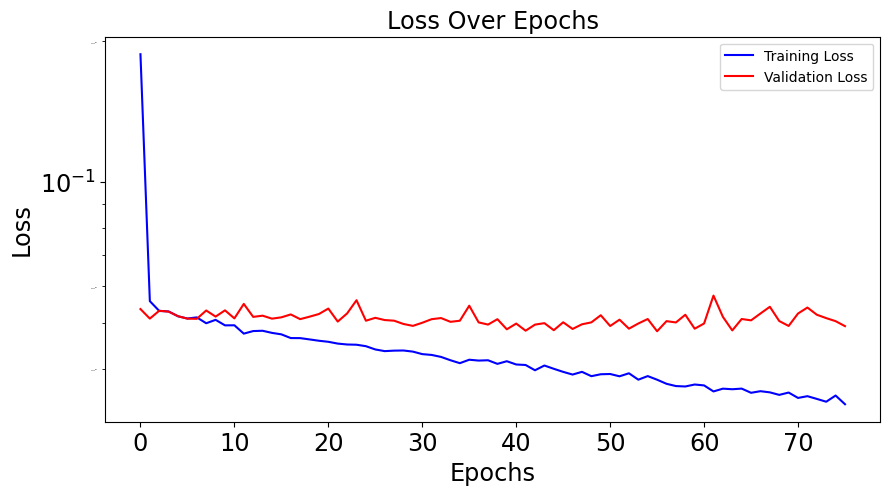

In [8]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
train_losses,val_losses = train_model(model, train_loader, criterion, optimizer ,filename='1NNepochs.png')
export_model_to_onnx(model, (x1_train, x2_train), onnx_file_name)

### Evaluate model

Mean Squared Error: 0.031948354095220566


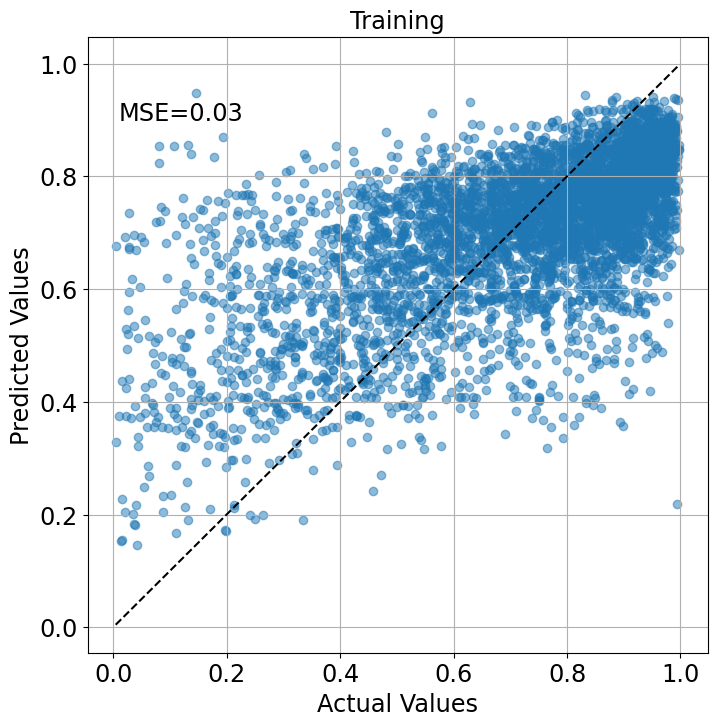

Mean Squared Error: 0.05062311515212059


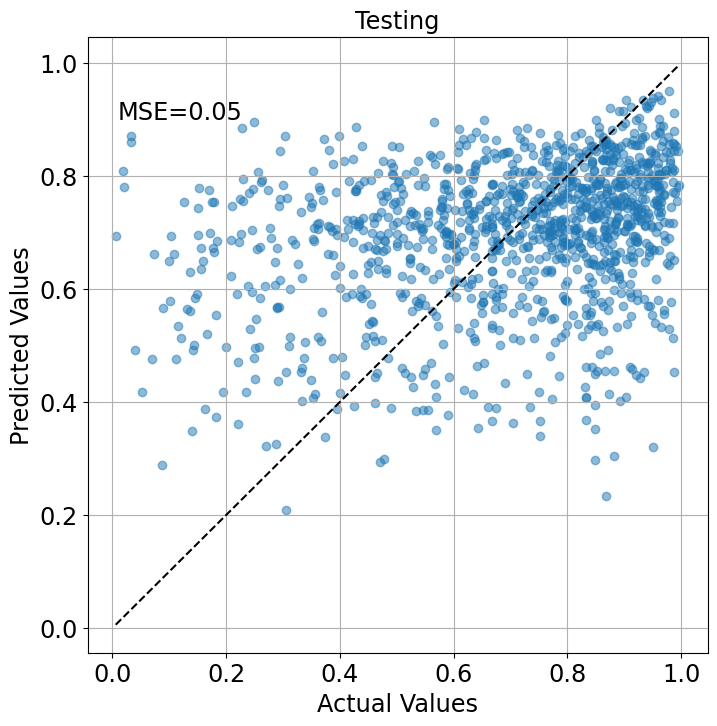

In [9]:
predictions_train, actuals_train = evaluate_model(model, train_loader)
mse = mean_squared_error(actuals_train, predictions_train)
print(f"Mean Squared Error: {mse}")
plot_predictions_vs_actuals(actuals_train, predictions_train,mse=mse,title="Training",filename='2NNtrain.png')
############################################################
predictions_test, actuals_test = evaluate_model(model, test_loader)
mse = mean_squared_error(actuals_test, predictions_test)
print(f"Mean Squared Error: {mse}")
plot_predictions_vs_actuals(actuals_test, predictions_test,mse=mse,title="Testing",filename='2NNtest.png')

# SHAP analysis

SHAP values shape: (1000, 40)
Features shape: (1000, 40)
Feature names length: 40


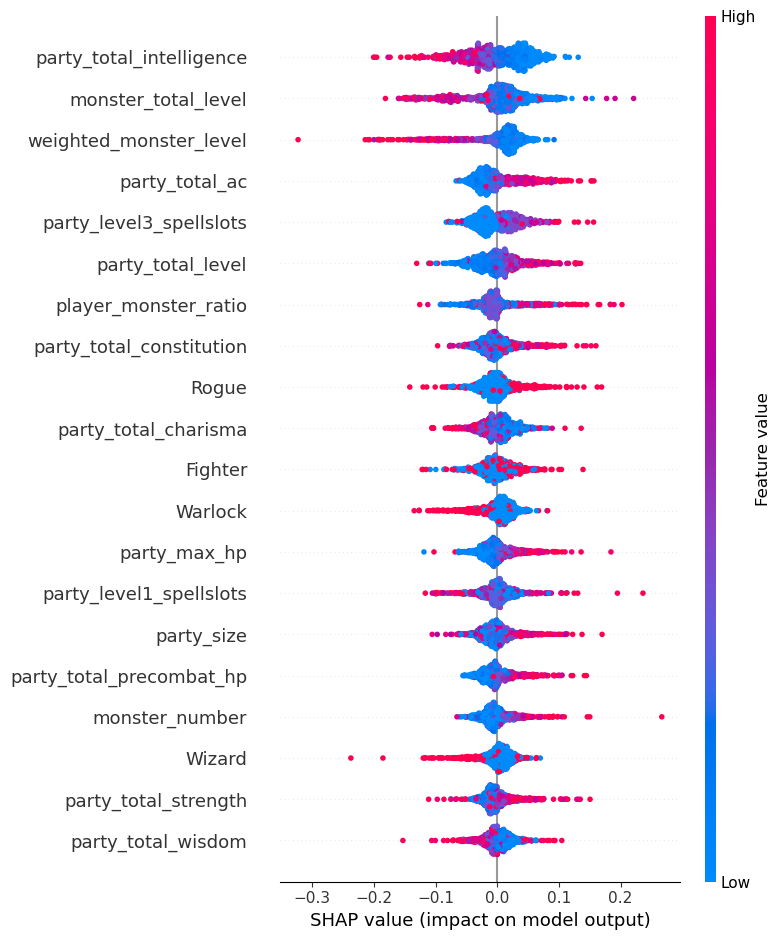

In [10]:
import shap

class PyTorchModelWrapper2NN(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs):
        x1 = inputs[:, :input_dim1]
        x2 = inputs[:, input_dim1:]
        return self.model(x1, x2)

# Preparing data
x_combined = torch.cat((x1_train[:1000], x2_train[:1000]), dim=1)
#x_combined = torch.cat((x1_train, x2_train), dim=1)

# Initialize the model wrapper and GradientExplainer
model_wrapper = PyTorchModelWrapper2NN(model).eval()
explainer = shap.GradientExplainer(model_wrapper, x_combined)

# Compute SHAP values
shap_values = explainer.shap_values(x_combined)
shap_values = shap_values[:,:,0]

# Convert tensors to numpy for compatibility with SHAP plotting
features_combined = x_combined.numpy()

# Define feature names appropriately
feature_names = x1_columns + x2_columns

# Debugging outputs
print("SHAP values shape:", np.shape(shap_values))
print("Features shape:", features_combined.shape)
print("Feature names length:", len(feature_names))

# SHAP Summary Plot
try:
    shap.summary_plot(shap_values, features=features_combined, feature_names=feature_names,show=False)
    plt.savefig('2NNSHAP.png',dpi=600,transparent=True)
    plt.show()
except Exception as e:
    print("Error during SHAP plotting:", e)




### Cross Validation

In [ ]:
x1_df = combat_data_df[x1_columns]#.iloc[:50,:]
x2_df = combat_data_df[x2_columns]#.iloc[:50,:]
Y_df = combat_data_df[y_columns]#.iloc[:50,:]
fold_losses = cross_validate_model(model_constructor=TwoPathNN,model_params=model_params,x_df=x1_df,Y_df=Y_df,x2_df=x2_df)
print(fold_losses)

## One NN Model

### Data Preparation

In [11]:
# DataLoader for the training and validation data
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Model Preparation

In [12]:
input_dim = len(x_columns)
hidden_dims = [20, 40, 80, 80, 40, 20]
model_params = {
    'input_dim': input_dim,
    'hidden_dims': hidden_dims,
}
                 
model = OnePathNN(**model_params)
output = model(x_train)
print(output.shape)

# ONNX model
onnx_file_name = 'one_path_nn.onnx'
export_model_to_onnx(model, x_train, onnx_file_name)

torch.Size([4712, 1])


### Model training

Finished Training


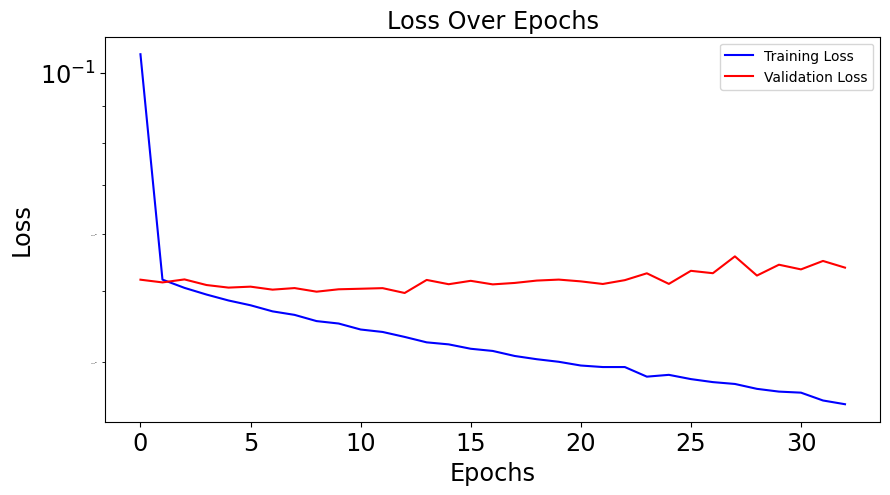

In [13]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
losses = train_model(model, train_loader, criterion, optimizer, filename='1NNepochs.png')
export_model_to_onnx(model, x_train, onnx_file_name)

### Model evaluation

Mean Squared Error: 0.03740865737199783


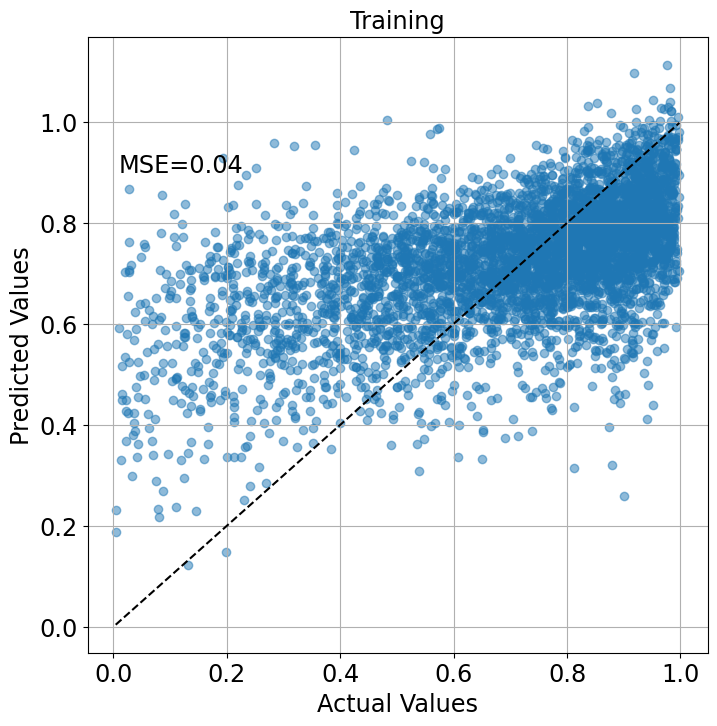

Mean Squared Error: 0.05235215649008751


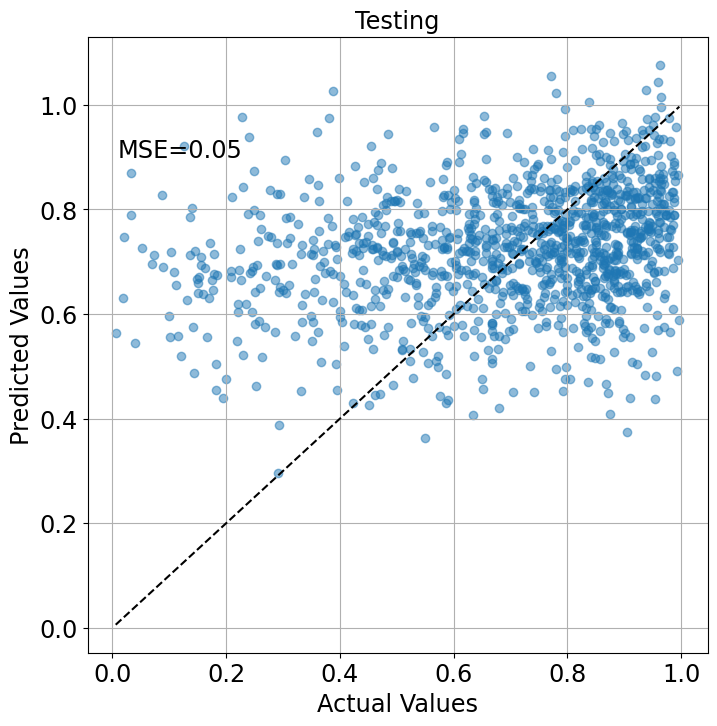

In [14]:
predictions_train, actuals_train = evaluate_model(model, train_loader)
mse = mean_squared_error(actuals_train, predictions_train)
print(f"Mean Squared Error: {mse}")
plot_predictions_vs_actuals(actuals_train, predictions_train,mse=mse,title="Training",filename='1NNtrain.png')
############################################################
predictions_test, actuals_test = evaluate_model(model, test_loader)
mse = mean_squared_error(actuals_test, predictions_test)
print(f"Mean Squared Error: {mse}")
plot_predictions_vs_actuals(actuals_test, predictions_test,mse=mse,title="Testing",filename='1NNtest.png')

SHAP values shape: (1000, 40)
Features shape: (1000, 40)
Feature names length: 40


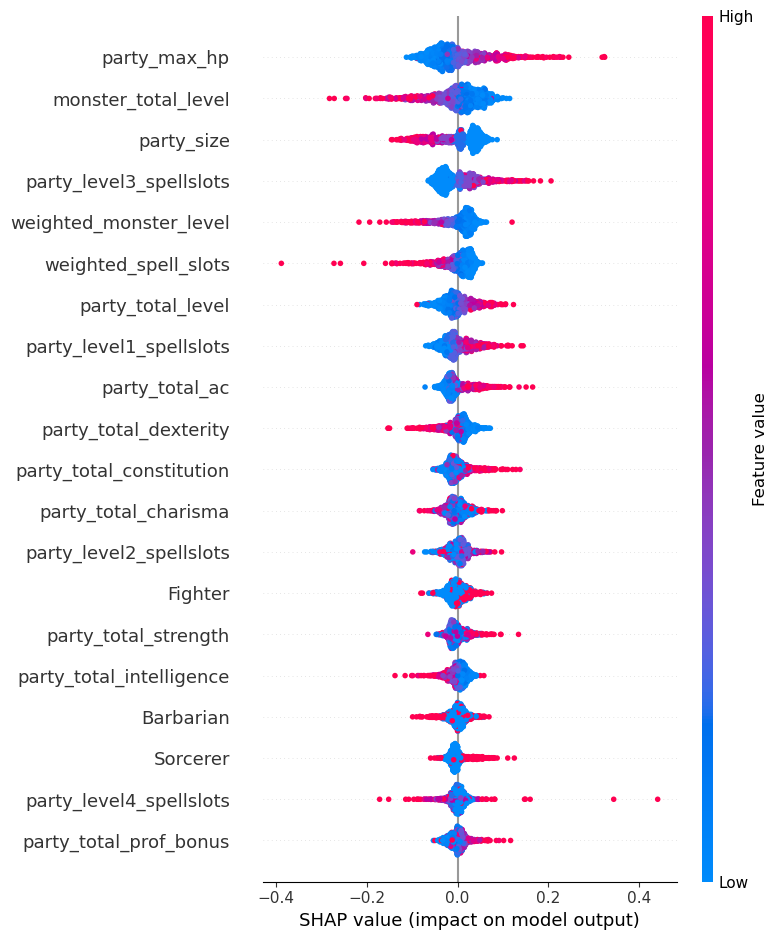

In [15]:
import shap

class PyTorchModelWrapper1NN(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x1):
        return self.model(x1)

# Preparing data
x_combined = x_train[:1000]
#x_combined = x1_train

# Initialize the model wrapper and GradientExplainer
model_wrapper = PyTorchModelWrapper1NN(model).eval()
explainer = shap.GradientExplainer(model_wrapper, x_combined)

# Compute SHAP values
shap_values = explainer.shap_values(x_combined)
shap_values = shap_values[:,:,0]

# Convert tensors to numpy for compatibility with SHAP plotting
features_combined = x_combined.numpy()

# Define feature names appropriately
feature_names = x_columns

# Debugging outputs
print("SHAP values shape:", np.shape(shap_values))
print("Features shape:", features_combined.shape)
print("Feature names length:", len(feature_names))

# SHAP Summary Plot
try:
    shap.summary_plot(shap_values, features=features_combined, feature_names=feature_names,show=False)
    plt.savefig('1NNSHAP.png',dpi=600,transparent=True)
    plt.show()
except Exception as e:
    print("Error during SHAP plotting:", e)



### Cross validation

In [ ]:
x_df = combat_data_df[x_columns].iloc[:50,:]
Y_df = combat_data_df[y_columns].iloc[:50,:]
fold_losses = cross_validate_model(model_constructor=OnePathNN,model_params = model_params,x_df = x_df, Y_df = Y_df)
print(fold_losses)